In [14]:
#!/usr/bin/python -tt 
# -*- coding: utf-8-sig -*-
import os
import sys
import glob
import numpy as np
import matplotlib.pyplot as plt
import codecs
import cv2
import keras
from keras.layers import Input,Dense, Dropout, Flatten,Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import LSTM,BatchNormalization
from keras.layers import Reshape, Lambda
from keras.layers.merge import add, concatenate
from keras.models import Model, load_model
from keras.layers.recurrent import GRU
from keras.optimizers import SGD,RMSprop,Adam
from keras import backend as K
from keras.models import model_from_json
from keras.callbacks import EarlyStopping
from keras.preprocessing import sequence
import itertools
import errno
import time
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.gridspec as gridspec

from sklearn.model_selection import train_test_split
from os.path import join
import random
import tensorflow as tf
import json as simplejson
import datetime as dt          
import Levenshtein
from keras.callbacks import CSVLogger
from contextlib import redirect_stdout
from keras.preprocessing import image
from collections import Counter
from keras import regularizers
from keras.utils.vis_utils import plot_model

def labels2text(labels,letters):
    txt=''.join(list(map(lambda x: letters[int(x)], labels)))
    return txt

def text2labels(text,letters):
    return list(map(lambda x: letters.index(x), text))

def is_valid_str(s,letters):
    for ch in s:
        if not ch in letters:
            return False
    return True

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage:
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

def decode_batch(out,letters):
    ret = []
    for j in range(out.shape[0]):
        out_best = list(np.argmax(out[j, 2:], 1))
        out_best = [k for k, g in itertools.groupby(out_best)]
        outstr = ''
        for c in out_best:
            if c < len(letters):
                outstr += letters[c]
        ret.append(outstr)
    return ret


In [33]:
def loadData(path,file,load=False):
    print(path+file)
    with codecs.open(path+file,'r','utf-8-sig') as f:
        rlines=f.readlines()
    data=[]
    label=[]
    max_len_label=[]
    texts=''
    for i,lines in enumerate(rlines):
#        text=lines.replace('\n','').replace('\ufeff',''
        line=lines.rstrip('\n').replace('\r','').replace('\ufeff','')
        txt=line.split('&')
        label.append(txt[1])
        texts=texts+txt[1]
        max_len_label.append(len(txt[1]))
        filesplit = txt[0].split('-')
        fullPath = path + 'Data/' + filesplit[0] + '/' + filesplit[1] + '/' + txt[0] + '.png'
        data.append(fullPath)
#        print(fullPath,txt[1])

    letter=sorted((Counter(texts).keys()))
    letter_len=len(letter)
    max_len = max(Counter(max_len_label).keys())

    if load:
        del rlines
        del filesplit
        del fullPath
        del data, label
        return max_len, letter
    else:
        x_train, x_valid, y_train, y_valid = train_test_split(data, label, test_size=0.3)
        print('Train : '+str(len(y_train)))
        print('Test : '+str(len(y_valid)))
        return x_train, x_valid, y_train, y_valid, max_len, letter

class GenerateData:

    def __init__(self,
                 dirpath,
                 letters,
                 X,
                 Y,
                 img_w,
                 img_h,
                 batch_size, 
                 pool_size,
                 max_text_len):
        self.letters = letters
        self.img_h = img_h
        self.img_w = img_w
        self.batch_size = batch_size
        self.downsample_factor = pool_size ** 2
        self.samples = []
        img_dirpath = dirpath
        img_filepath=X
        transcription=Y

        if len(transcription)==len(img_filepath):
            for i in range(len(img_filepath)):
                if is_valid_str(transcription[i],self.letters):
                    self.samples.append([join(img_dirpath,img_filepath[i]), transcription[i]])
                else:
                    print('Image file %s does not match to transcription [%s].' % (img_filepath[i],transcription[i]))
                    
        self.max_text_len=max_text_len
        self.n = len(self.samples)
        self.cur_index = 0

    def create_data(self,train=True):
        self.imgs = []
#        self.augs = []
        self.texts = []
        self.file_name=[]
        for i, (img_filepath, text) in enumerate(self.samples):
            img = cv2.imread(img_filepath,0)
#            img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            img = cv2.resize(img, (self.img_w, self.img_h), interpolation = cv2.INTER_CUBIC)
            img = img.astype(np.float32)
            img /= 255.0
            # width and height are backwards from typical Keras convention
            # because width is the time dimension when it gets fed into the RNN
            tmp1=np.expand_dims(img, -1)
#            tmp1=img
            self.imgs.append(tmp1)
            num_aug=1
            # generate augmenation
            if (train):
                img_t=image.random_rotation(tmp1, 30, row_axis=0, col_axis=1)
                self.imgs.append(img_t)
                img_t=image.random_shear(tmp1, 0.2, row_axis=0, col_axis=1)
                self.imgs.append(img_t)
                img_t=image.random_shift(tmp1, 0.2, 0.2, row_axis=0, col_axis=1)
                self.imgs.append(img_t)
                img_t=image.random_zoom(tmp1, (0.8,0.8), row_axis=0, col_axis=1)
                self.imgs.append(img_t)
                num_aug=5
            for j in range(num_aug):
                self.texts.append(text) 
                self.file_name.append(img_filepath)
                    
        self.n_aug=len(self.imgs)
        self.indexes = random.sample(list(range(self.n_aug)),self.n_aug)
    
    def next_sample(self):
        self.cur_index += 1
        if self.cur_index >= self.n_aug:
            self.cur_index = 0
            random.shuffle(self.indexes)
        return self.indexes[self.cur_index]
    
    def next_batch(self):
        while True:
            X_data = np.ones([self.batch_size, self.img_w, self.img_h, 1])
            Y_data = np.zeros([self.batch_size, self.max_text_len])
            input_length = np.ones((self.batch_size, 1)) * (self.img_w // self.downsample_factor - 2)
            label_length = np.zeros((self.batch_size, 1))
            file_name = []
                                   
            for i in range(self.batch_size):
                idx = self.next_sample()
                if idx>=self.n_aug:
                    print(idx)
                    break
                X_data[i]= np.expand_dims(self.imgs[idx].T, -1)
#                X_data[i] = np.reshape(self.imgs[idx],(self.img_w,self.img_h,1))
                file_name.append(self.file_name[idx])
                lab=text2labels(self.texts[idx],letters)
                for k,l in enumerate(lab):
                    Y_data[i][k]=l
                label_length[i] = len(self.texts[idx])
                
            inputs = {
                'the_input': X_data,
                'the_labels': Y_data,
                'input_length': input_length,
                'label_length': label_length,
                'file_name': file_name
            }
            outputs = {'ctc': np.zeros([self.batch_size])}
            yield (inputs, outputs)

def create_model(newpath,img_h,img_w,epochs,rnn_size,batch_size,
                 max_len,num_classes, pool_size, load=False):
    # Network parameters
    conv_filters1 = 16
    conv_filters2 = 32
    kernel_size = (3, 3)
    time_dense_size = 64
#    stop_here = EarlyStopping(monitor='val_loss',patience=5,verbose=0)
    
    input_shape = (img_w, img_h, 1)
    
    act = 'relu'
    #act = 'tanh'
    input_data = Input(name='the_input', shape=input_shape, dtype='float32')
    inner = Conv2D(conv_filters1, kernel_size, padding='same',
                   activation=act, 
                   kernel_initializer='he_normal', name='conv1')(input_data)
#    inner = BatchNormalization()(inner)
#    inner = Activation(act)(inner)
    inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)
    # adding dropout
    inner = Dropout(0.2)(inner)
    inner = Conv2D(conv_filters2, kernel_size, padding='same',
                   activation=act, 
                   kernel_initializer='he_normal', name='conv2')(inner)
#    inner = BatchNormalization()(inner)
#    inner = Activation(act)(inner)
    inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)
    # adding dropout
    inner = Dropout(0.2)(inner)
    inner = Conv2D(conv_filters2, kernel_size, padding='same',
                   activation=act, 
                   kernel_initializer='he_normal', name='conv3')(inner)
#    inner = BatchNormalization()(inner)
#    inner = Activation(act)(inner)
    inner = MaxPooling2D(pool_size=(1, 1), name='max3')(inner)
    inner = Dropout(0.2)(inner)
    print(inner.shape)
    conv_to_rnn_dims = (img_w // (pool_size ** 2), (img_h // (pool_size ** 2)) * conv_filters2)
    print(conv_to_rnn_dims)
    inner = Reshape(target_shape=conv_to_rnn_dims, name='reshape')(inner)

    # cuts down input size going into RNN:
    weight_decay=0.001
    inner = Dense(time_dense_size, activation=act, name='dense1', 
                  kernel_regularizer=regularizers.l2(weight_decay))(inner)

    # Two layers of bidirecitonal GRUs
    # GRU seems to work as well, if not better than LSTM:
    gru_1 = GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru1')(inner)
    gru_1b = GRU(rnn_size, return_sequences=True, go_backwards=True,dropout=0.2,recurrent_dropout=0.2, 
                    kernel_initializer='he_normal', name='gru1_b')(inner)
    gru1_merged = add([gru_1, gru_1b])
    gru_2 = GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru2')(gru1_merged)
    gru_2b = GRU(rnn_size, return_sequences=True, go_backwards=True,dropout=0.2,recurrent_dropout=0.2, 
                kernel_initializer='he_normal', name='gru2_b')(gru1_merged)
    # transforms RNN output to character activations:
    inner = Dense(num_classes, kernel_initializer='he_normal',name='dense2', 
                  kernel_regularizer=regularizers.l2(weight_decay))(concatenate([gru_2, gru_2b]))

    y_pred = Activation('softmax', name='softmax')(inner)

    labels = Input(name='the_labels', shape=[x_train.max_text_len], dtype='float32')
    input_length = Input(name='input_length', shape=[1], dtype='int64')
    label_length = Input(name='label_length', shape=[1], dtype='int64')
    # so CTC loss is implemented in a lambda layer
    loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])

    #opt = SGD(lr=0.02, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5)
    #opt=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
    opt = RMSprop(lr=0.001, rho=0.9, epsilon=1e-6) 
    model = Model(inputs=[input_data, labels, input_length, label_length], outputs=loss_out)
        # the loss calc occurs elsewhere, so use a dummy lambda func for the loss
    model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=opt)
    if load:
        # load weights into new model
        print("Loaded model from disk")
    #        model = load_model(newpath+'model.h5', compile=False)
        model=Model(inputs=input_data, outputs=y_pred)
        try:
            model.load_weights(newpath+'weight.h5')
            print("...Previous weight data...")
        except:
            print("...New weight data...")
            pass
        
    else:
        with open(newpath+'model_summary.txt', 'w') as f:
            with redirect_stdout(f):
                Model(inputs=input_data, outputs=y_pred).summary()

#    if not load:
        # captures output of softmax so we can decode the output during visualization
    test_func = K.function([input_data], [y_pred])
    return model

def generateEvaluationGraph(history,i):
    # Loss curves
    f,(ax1,ax2)=plt.subplots(1,2,figsize=(16,6))    
    f.suptitle('Fold: '+str(i),fontsize=18)
    ax1.plot(history.history['loss'],'r',linewidth=3.0)
    ax1.plot(history.history['val_loss'],'b',linewidth=3.0)
    ax1.legend(['Training set', 'Valid set'],fontsize=16)
    ax1.set_xlabel('Epochs ',fontsize=16)
    ax1.set_ylabel('CER %',fontsize=16)
    ax1.set_title('Loss Curves',fontsize=16)
 
    return f
        
def writeResult(finame,xx,model,letters,sess):
    net_inp = model.get_layer(name='the_input').input
    net_out = model.get_layer(name='softmax').output    
    cnt=0
    tot=0
    k=1
    r=0
    with codecs.open(finame+'_result.txt','w','utf-8-sig') as fi:
        str1='File Prediction'
        fi.write(str1+'\n')
        
        for inp_value, _ in xx.next_batch():
            bs = inp_value['the_input'].shape[0]
            X_data = inp_value['the_input']
            net_out_value = sess.run(net_out, feed_dict={net_inp:X_data})
            pred = decode_batch(net_out_value,letters)
            labels = inp_value['the_labels']
            label_length = inp_value['label_length']
            file_name = inp_value['file_name']
            texts = []
            for label in labels:
                text = ''.join(list(map(lambda x: letters[int(x)], label)))
                texts.append(text)

            for i in range(bs):
                tot +=label_length[i]
                str1='Sample No.:%d, file_name: %s'% (k,file_name[i])
                fi.write(str1+'\n')
                fi.write('Predicted: %s\nTrue: %s\n' % (pred[i], texts[i]))
                c=label_length[i]-Levenshtein.distance(texts[i].rstrip(),pred[i].rstrip())
                cnt+=c
                str1='#Corrected characters is %d from %d (%.4f%%)'%(c,label_length[i],c/label_length[i]*100)
                fi.write(str1+'\n')
                s=Levenshtein.ratio(texts[i].rstrip(),pred[i].rstrip())
                r += s
                str1='Match sequence ratio is %.4f%%' % (s*100)
                fi.write(str1+'\n')
                k=k+1
            if k>xx.n_aug:
                break
        str1='\nTotal corrected characters is %d from %d (%.4f%%)'%(cnt,tot,cnt/tot*100)
        print(str1)
        fi.write(str1+'\n')
        str1='Match sequence average ratio is %.4f%%' % ((r/(k-1)*100))
        print(str1)
        fi.write(str1+'\n')

def training(path,letters,max_len,x_train,x_valid, pool_size,batch_size, 
           img_h,img_w,rnn_size=128,epochs=30):
        ### start session
    session_config = K.tf.ConfigProto(log_device_placement=False, allow_soft_placement=True)    
    # please do not use the totality of the GPU memory
    session_config.gpu_options.per_process_gpu_memory_fraction = 0.90
    stop_here = EarlyStopping(monitor='loss',patience=5,verbose=0)

    sess = tf.Session()
    K.set_session(sess)

    # in 1 epoch = number of training examples/batch_size
    print('epochs=',epochs)
 
    start=time.time()
    done = time.time()
    elapsed = done - start
    print(time.strftime("ETA of load image files=%H:%M:%S", time.gmtime(elapsed)))
    start_all=time.time()

    newpath = path+'augment/result_h{}_b{}_{}/'.format(rnn_size,batch_size,
                dt.datetime.now().strftime('%Y%m%d_%H')) 
    if not os.path.exists(newpath):
        os.makedirs(newpath)
    
    model=create_model(newpath,img_h,img_w,epochs,rnn_size,batch_size,
                 max_len,num_classes, pool_size)
    csv_logger = CSVLogger(newpath+'history.log',append=True, separator=',') 
    steps_per_epoch=x_train.n_aug//batch_size
    valid_steps=x_valid.n_aug//batch_size
    history=model.fit_generator(generator=x_train.next_batch(), steps_per_epoch=steps_per_epoch,epochs=epochs,
                         validation_data=x_valid.next_batch(),validation_steps=valid_steps,
                         callbacks=[csv_logger])

    done_all = time.time()
    elapsed = done_all - start_all
    print(time.strftime("ETA of all rounds=%H:%M:%S", time.gmtime(elapsed)))

    # serialize model to JSON
    model_json = model.to_json()
    with open(newpath+"model.json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save(newpath+'model.h5')
    model.save_weights(newpath+'weight.h5')
    print("Save model to disk...")

    fig=generateEvaluationGraph(history,1)
    try:
        with PdfPages(newpath+'plot.pdf') as pdf:
            pdf.savefig(fig)
    except ValueError:
        print('error save plot.pdf')

    writeResult(newpath+'train',x_train,model,letters,sess)
    writeResult(newpath+'test',x_test,model,letters,sess)
    plot_model(model, to_file=newpath+'model_plot.png', show_shapes=True, show_layer_names=True)

    return model
 

In [23]:
### main
path='d:/hwr/'
print('Loading dataset...')
Xdata_train,Xdata_test,Ydata_train,Ydata_test,max_len,letters=loadData(path,'wordsdata.txt')
print(letters)
num_classes=len(letters)+1

print('A number of class=',num_classes)

pool_size=2
img_w=320
img_h=64
batch_size=16
print('batch_size=',batch_size)
# Generate image and label
print('Generating images and labels...')
x_train = GenerateData(path,letters,Xdata_train,Ydata_train,img_w, img_h, batch_size, pool_size,max_len)
x_train.create_data(train=True)
print('A number of training samples with augmentation=',x_train.n_aug)
x_test = GenerateData(path,letters,Xdata_test,Ydata_test, img_w, img_h, batch_size, pool_size,max_len)
x_test.create_data(train=False)
print('A number of test/valid samples with augmentation=',x_test.n_aug)
del Xdata_train
del Xdata_test

Loading dataset...
d:/hwr/wordsdata.txt
Train : 669
Test : 288
[' ', 'ก', 'ข', 'ค', 'ฆ', 'ง', 'จ', 'ฉ', 'ช', 'ซ', 'ฌ', 'ญ', 'ฎ', 'ฏ', 'ฐ', 'ฑ', 'ฒ', 'ณ', 'ด', 'ต', 'ถ', 'ท', 'ธ', 'น', 'บ', 'ป', 'ผ', 'ฝ', 'พ', 'ฟ', 'ภ', 'ม', 'ย', 'ร', 'ฤ', 'ล', 'ว', 'ศ', 'ษ', 'ส', 'ห', 'ฬ', 'อ', 'ฮ', 'ฯ', 'ะ', 'ั', 'า', 'ำ', 'ิ', 'ี', 'ึ', 'ื', 'ุ', 'ู', 'เ', 'แ', 'โ', 'ใ', 'ไ', 'ๆ', '็', '่', '้', '๊', '๋', '์']
A number of class= 68
batch_size= 16
Generating images and labels...
A number of training samples with augmentation= 3345
A number of test/valid samples with augmentation= 288


72
epochs= 100
ETA of load image files=00:00:00
(?, 80, 16, 32)
(80, 512)
Epoch 1/100
209/209 [==============================] - 57s 273ms/step - loss: 199.9927 - val_loss: 192.9311
Epoch 2/100
209/209 [==============================] - 55s 263ms/step - loss: 184.4630 - val_loss: 170.6595
Epoch 3/100
209/209 [==============================] - 55s 264ms/step - loss: 165.7112 - val_loss: 147.0966
Epoch 4/100
209/209 [==============================] - 55s 262ms/step - loss: 147.5126 - val_loss: 117.6607
Epoch 5/100
209/209 [==============================] - 55s 263ms/step - loss: 124.0981 - val_loss: 91.0704
Epoch 6/100
209/209 [==============================] - 55s 264ms/step - loss: 104.2830 - val_loss: 70.1871
Epoch 7/100
209/209 [==============================] - 55s 263ms/step - loss: 89.5533 - val_loss: 57.0683
Epoch 8/100
209/209 [==============================] - 55s 263ms/step - loss: 74.9862 - val_loss: 49.8843
Epoch 9/100
209/209 [==============================] - 55s 263ms/ste

Epoch 77/100
209/209 [==============================] - 55s 262ms/step - loss: 26.6900 - val_loss: 21.2576
Epoch 78/100
209/209 [==============================] - 55s 263ms/step - loss: 20.8232 - val_loss: 18.3824
Epoch 79/100
209/209 [==============================] - 54s 261ms/step - loss: 20.8636 - val_loss: 25.3825
Epoch 80/100
209/209 [==============================] - 55s 261ms/step - loss: 138.2581 - val_loss: 182.7292
Epoch 81/100
209/209 [==============================] - 55s 262ms/step - loss: 70.0623 - val_loss: 25.8741
Epoch 82/100
209/209 [==============================] - 55s 261ms/step - loss: 97.1324 - val_loss: 142.8658
Epoch 83/100
209/209 [==============================] - 55s 262ms/step - loss: 37.6340 - val_loss: 13.3820
Epoch 84/100
209/209 [==============================] - 55s 262ms/step - loss: 22.7781 - val_loss: 24.8749
Epoch 85/100
209/209 [==============================] - 55s 263ms/step - loss: 25.4027 - val_loss: 33.3949
Epoch 86/100
209/209 [============

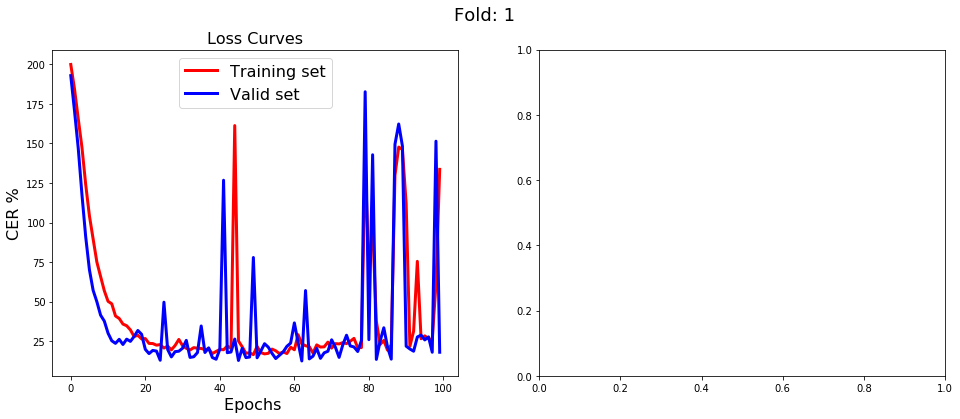

In [28]:
print(max_len)
training(path,letters,max_len,x_train,x_test, pool_size,batch_size, 
       img_h,img_w,rnn_size=256,epochs=100)

K.clear_session()

In [ ]:

### main
path='d:/hwr/'
print('Loading dataset...')
max_len,letters=loadData(path,'wordsdata.txt',load=True)
print(letters)
num_classes=len(letters)+1

print('A number of class=',num_classes)

In [ ]:
def decode_predict_ctc(out,letters, top_paths = 1):
    results = []
    beam_width = 5
    if beam_width < top_paths:
        beam_width = top_paths
    for i in range(top_paths):
        lables = K.get_value(K.ctc_decode(out, input_length=np.ones(out.shape[0])*out.shape[1],
                           greedy=False, beam_width=beam_width, top_paths=top_paths)[0][i])[0]
        text = labels2text(lables,letters)
        results.append(text)
    return results
  
def predit_a_image(a, top_paths = 1):
    c = np.expand_dims(a.T, axis=0)
    net_out_value = model_p.predict(c)
    top_pred_texts = decode_predict_ctc(net_out_value, top_paths)
    return top_pred_texts

pool_size=2
img_w=320
img_h=64
batch_size=16
print('num_classes=',num_classes)
print('batch_size=',batch_size)

print("Loaded model from disk")
# Get CRNN model
epochs=100
rnn_size=256
model=create_model('D:/HWR/augment/result_h256_b16_20190128_11/',img_h,img_w,epochs,rnn_size,batch_size,
        max_len,num_classes, pool_size, load=True)

num_classes= 68
batch_size= 16
Loaded model from disk
(?, 80, 16, 32)
(80, 512)
Loaded model from disk
...Previous weight data...
D:/HWR/test2.png


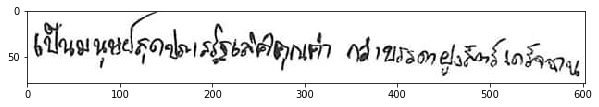

(320, 64, 1)
(1, 320, 64, 1)
(1, 320, 64, 1)
['เป็นมนุษ์สุดประเสริฐเลิศคุณค่า กว่าบรดาฝูงสัตว์เงสัตจฉา์']


In [63]:
filename="D:/HWR/test2.png"
#print('test2')
print(filename)
img = cv2.imread(filename,0)
fig = plt.figure(figsize=(10, 10))
plt.imshow(img, cmap='gray')
plt.show()

#cv2.imshow('image',img)
#cv2.waitKey(0)
img = cv2.resize(img, (img_w, img_h), interpolation = cv2.INTER_CUBIC)
img = img.astype(np.float32)
img /= 255.0
#img = np.reshape(img,(img_w,img_h,1))
img = np.expand_dims(img.T,-1)
print(img.shape)

x_data=np.expand_dims(img, 0)
print(x_data.shape)
inputs=x_data
print(inputs.shape)
net_out_value=model.predict(inputs)
#print(net_out_value)
pred_texts = decode_predict_ctc(net_out_value,letters)
#pred_texts = decode_batch(net_out_value,letters)
print(pred_texts)


#c = np.expand_dims(a.T, axis=0)

#net_out_value = model_p.predict(c)
#pred_texts = decode_predict_ctc(net_out_value)
#pred_texts